In [1]:
#import modul yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#import data untuk training
x_train = pd.read_csv('feature_train.csv')
y_train = pd.read_csv('label_train.csv')

## Scaling

Saya melakukan proses scaling setelah data dipisahkan. Hal ini dilakukan untuk meminimalisir *data leakage* seperti yang dibahas dalam artikel https://machinelearningmastery.com/data-leakage-machine-learning/

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
Scaler = StandardScaler()
Scaler = Scaler.fit(x_train)
x_train = Scaler.transform(x_train)
x_train

array([[ 1.13646011,  1.3157337 ,  1.03394431, ...,  1.46316269,
        -0.01624353, -1.46227393],
       [-0.079549  , -1.40327543, -0.96742555, ..., -0.683451  ,
        -0.01624353,  0.6838664 ],
       [-0.079549  , -0.24975641,  1.03394431, ..., -0.683451  ,
        -0.01624353,  0.6838664 ],
       ...,
       [-0.079549  ,  0.40939732,  1.03394431, ...,  1.46316269,
        -0.01624353, -1.46227393],
       [ 1.13646011, -0.08496798,  1.03394431, ...,  1.46316269,
        -0.01624353, -1.46227393],
       [-1.29555811, -0.90891013, -0.96742555, ..., -0.683451  ,
        -0.01624353,  0.6838664 ]])

## Training

In [15]:
#import model yang digunakan yaitu random forest
from sklearn.ensemble import RandomForestRegressor

In [16]:
reg = RandomForestRegressor(random_state=0)

In [17]:
reg = reg.fit(x_train,y_train)

C:\Users\Rizaldi\AppData\Local\Temp\ipykernel_10228\4168448519.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg = reg.fit(x_train,y_train)


In [18]:
reg.score(x_train,y_train)

0.9370672718028137

In [19]:
#import data validation
x_test = pd.read_csv('feature_test.csv')
y_test = pd.read_csv('label_test.csv')

In [20]:
#Scaling feature test
x_test_scaled = Scaler.transform(x_test)

In [21]:
y_pred = reg.predict(x_test_scaled)

In [22]:
reg.score(x_test_scaled,y_test)

0.5404941542530026

C:\Users\Rizaldi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Rizaldi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

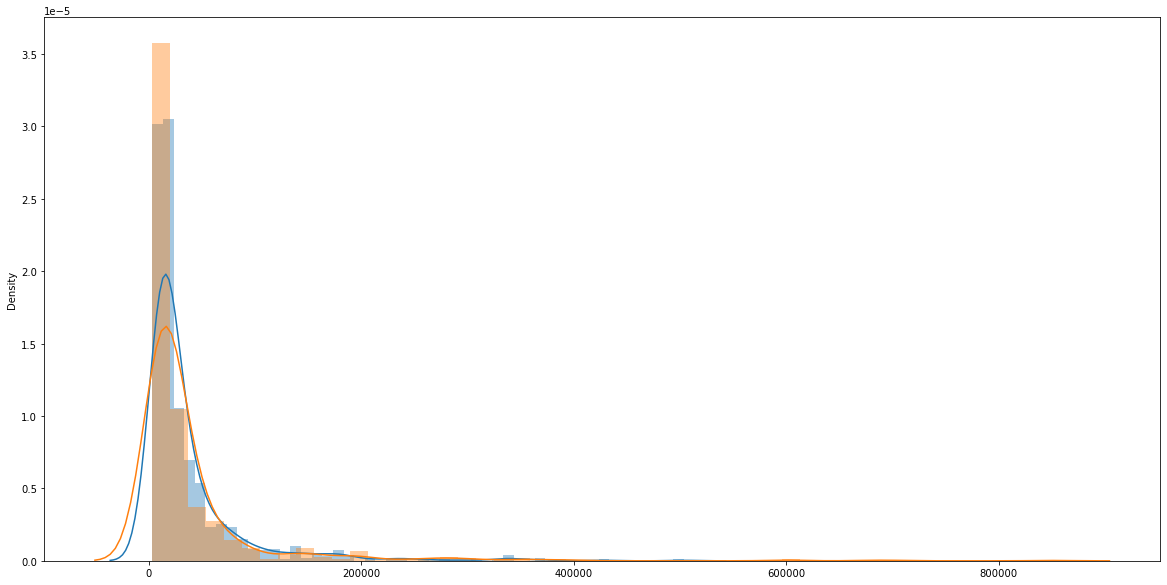

In [23]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.distplot(y_pred)
sns.distplot(y_val)

Terlihat bahwa untuk rentang harga tertentu model telah melakukan prediksi dengan baik sedangkan pada rentang harga yang lain performa model masih kurang baik. Nila $R^{2}$ yang dihasilkan pun masih tergolong kurang baik

## Hyperparameter Tunning

Pada bagian ini dilakukan proses hyperparameter tunning untuk mencoba meningkatkan performa model. Hyperparameter dilakukan dengan dua langkah yaitu melakukan hyperparameter tunning dengan Random Search terlebih dahulu kemudian dilanjutkan dengan hyperparameter menggunakan Grid Search. (https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

#### Random Search

In [25]:
from pprint import pprint
# Parameter yang digunakan oleh random forest yang sedang digunakan
print('Parameters yang sedang digunakan:\n')
pprint(reg.get_params())

Parameters yang sedang digunakan:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Jumlah trees 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Jumlah features
max_features = ['auto', 'sqrt']
# Maximum depth
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum sample split
min_samples_split = [2, 5, 10]
# Jumlah minimum sample pada tiap leaf node
min_samples_leaf = [1, 2, 4]
# Bootstrap
bootstrap = [True, False]
# Membuat random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [27]:
rf = RandomForestRegressor()
# Random search dari parameter, menggunakan 3 fold cross validation, dengan jumlah parameter yang disampelkan adalah 100 (100 kombinasi)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Rizaldi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [28]:
# Model dengan hyperparameter terbaik hasil random search
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [29]:
# fungsi untuk evaluasi model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - np.array(test_labels))
    mape = 100 * np.mean(errors / np.array(test_labels))
    accuracy = 100 - mape
    print('Performa Model')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))

In [30]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test_scaled, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test_scaled, y_test)


C:\Users\Rizaldi\AppData\Local\Temp\ipykernel_10228\1362002935.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train)


Performa Model
Average Error: 42991.6115.
Performa Model
Average Error: 40916.1574.


Berdasarkan perbandingan rata-rata eror tersebut, terlihat setelah dilakukan hyperparameter tuning performa model semakin meningkat dengan ditandai nilai eror yang semakin mengecil

In [31]:
# Nilai R^2 hasil hyperparameter tuning
best_random.score(x_test_scaled,y_test)

0.5744540351550578

#### Grid Search

In [32]:
from sklearn.model_selection import GridSearchCV
# Membuat grid parameter berdasarkan hasil random search
param_grid = {
    'bootstrap': [False],
    'max_depth': [10, 20, 30, 40],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [5, 8, 11],
    'n_estimators': [1600, 1650, 1700, 1750]
}

rf2 = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf2, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [33]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


C:\Users\Rizaldi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [10, 20, 30, 40],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [5, 8, 11],
                         'n_estimators': [1600, 1650, 1700, 1750]},
             verbose=2)

In [34]:
# hyperparameter terbaik hasil dari grid search
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1600}

In [35]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test_scaled, y_test)

Performa Model
Average Error: 40917.7182.


In [36]:
best_grid.score(x_test_scaled,y_test)

0.5738448417519716

Performa model hasil dari grid search tidak berbeda jauh dengan hasil yang diperoleh oleh random search. Oleh karena itu model tersebut sudah menjadi model akhir dari prediksi ini

In [38]:
y_pred_test = best_grid.predict(x_test_scaled)

C:\Users\Rizaldi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Rizaldi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


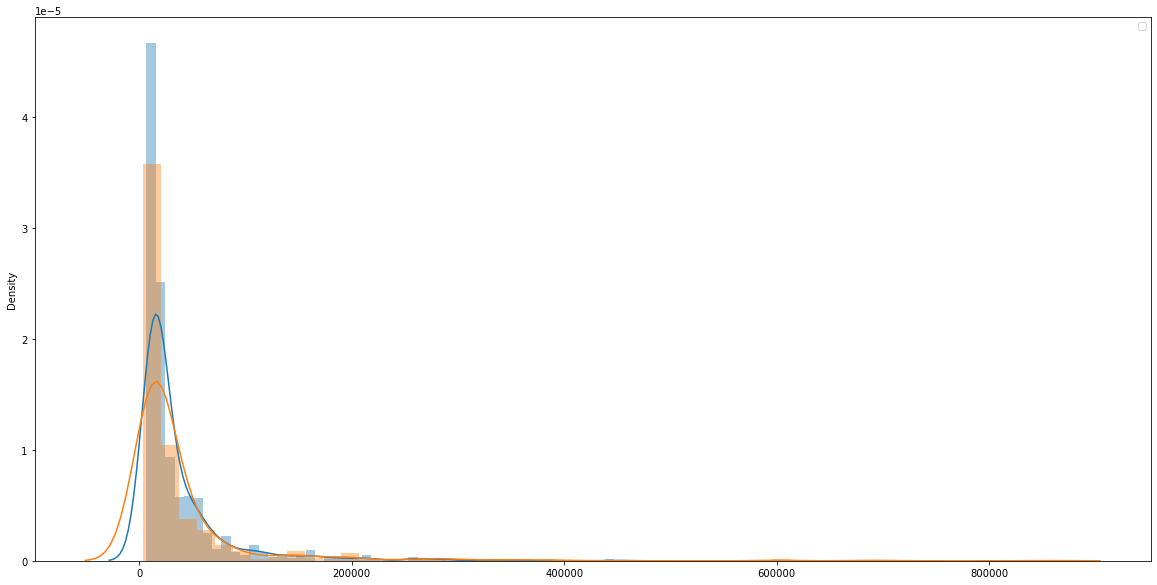

In [39]:
plt.figure(figsize=(20,10))
sns.distplot(y_pred_test)
sns.distplot(y_test)
plt.legend()

In [40]:
true = np.array(y_test).reshape(-1)
prediction = np.array(y_pred_test).reshape(-1)

In [41]:
true.shape

(948,)

In [42]:
hasil = pd.DataFrame({'True_val':true,'Prediction_val':prediction})
hasil

,True_val,Prediction_val
0,17000,15371.754895
1,30000,140895.336757
2,16000,15430.675779
3,90000,130817.588299
4,18000,37182.281755
...,...,...
943,170000,105284.814783
944,20000,33807.366557
945,7500,12500.403856
946,9500,11613.085214


In [43]:
def cat(df):
    val = 0
    if df < 10000:
        val = 'dibawah 10k'
    elif (df >= 10000) and (df < 5e4):
        val = '10k sampai <50k'
    elif (df >= 50000) and (df <= 1e5):
        val = '50k sampai 100k'    
    else:
        val = 'diatas 100k'
    return val

In [44]:
hasil['Category'] = hasil['True_val'].apply(cat)

In [45]:
hasil['diff'] = (abs(hasil['True_val']-hasil['Prediction_val'])/hasil['True_val'])*100

In [47]:
hasil

,True_val,Prediction_val,Category,diff
0,17000,15371.754895,10k sampai <50k,9.577912
1,30000,140895.336757,10k sampai <50k,369.651123
2,16000,15430.675779,10k sampai <50k,3.558276
3,90000,130817.588299,50k sampai 100k,45.352876
4,18000,37182.281755,10k sampai <50k,106.568232
...,...,...,...,...
943,170000,105284.814783,diatas 100k,38.067756
944,20000,33807.366557,10k sampai <50k,69.036833
945,7500,12500.403856,dibawah 10k,66.672051
946,9500,11613.085214,dibawah 10k,22.243002


In [48]:
hasil.groupby('Category')['diff'].mean()

Category
10k sampai <50k    39.497867
50k sampai 100k    36.978546
diatas 100k        42.835840
dibawah 10k        64.552800
Name: diff, dtype: float64

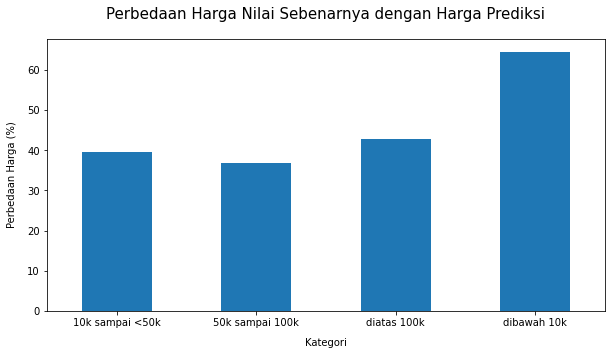

In [49]:
hasil.groupby('Category')['diff'].mean().plot(kind='bar', figsize=(10,5))
plt.title('Perbedaan Harga Nilai Sebenarnya dengan Harga Prediksi', fontsize=15, pad=20)
plt.ylabel('Perbedaan Harga (%)', labelpad=10)
plt.xlabel('Kategori', labelpad=10)
plt.xticks(rotation=0)
plt.show()

Berdasarkan tabel serta grafik diatas, umumnya perbedaan harga yang dihasilkan oleh model sudah berada dibawah 50% kecuali untuk rentang harga dibawah 10.000. Menurut saya performa ini tidak terlalu buruk dan masih dapat diterima

## Model dengan Nilai Label yang Diskalakan

Seperti yang dibahas pada bagian pre-processing, nilai sewa (rent) memiliki rentang yang sangat besar. Nilai yang besar ini bisa membuat performa model menjadi kurang baik. Pada bagian ini saya mencoba melakukan *scaling* pada nilai sewa dan ingin melihat dampak yang dihasilkan pada performa model.

## Scaling Nilai Label

In [52]:
y_train_scaled = np.log10(y_train)

In [53]:
y_train_scaled

,Rent
0,4.732394
1,4.204120
2,4.146128
3,4.690196
4,4.477121
...,...
3786,5.602060
3787,3.903090
3788,4.517196
3789,4.491362


In [54]:
rf2 = RandomForestRegressor()
# Random search dari parameter, menggunakan 3 fold cross validation, dengan jumlah parameter yang disamplekan adalah 100 (100 kombinasi)
rf2_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf2_random.fit(x_train, y_train_scaled)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Rizaldi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [55]:
rf2_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [56]:
y_test_scaled = np.log10(y_test)

In [60]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
base_model.fit(x_train, y_train_scaled)
base_accuracy = evaluate(base_model, x_test_scaled, y_test_scaled)

best_random = rf2_random.best_estimator_
random_accuracy = evaluate(best_random, x_test_scaled, y_test_scaled)


C:\Users\Rizaldi\AppData\Local\Temp\ipykernel_10228\2456181477.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(x_train, y_train_scaled)


Performa Model
Average Error: 0.4371.
Performa Model
Average Error: 0.4183.


In [61]:
best_random.score(x_test_scaled,y_test_scaled)

0.7509640335875674

In [63]:
param_grid2 = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [5, 8, 11],
    'n_estimators': [1000, 1050, 1100, 1150]
}

rf_scaled = RandomForestRegressor()
grid_search_scaled = GridSearchCV(estimator = rf_scaled, param_grid = param_grid2, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [64]:
grid_search_scaled.fit(x_train, y_train_scaled)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


C:\Users\Rizaldi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, 30, 40],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [5, 8, 11],
                         'n_estimators': [1000, 1050, 1100, 1150]},
             verbose=2)

In [65]:
grid_search_scaled.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1050}

In [67]:
best_grid_scaled = grid_search_scaled.best_estimator_
grid_accuracy_scaled = evaluate(best_grid_scaled, x_test_scaled, y_test_scaled)

Performa Model
Average Error: 0.4187.


In [69]:
best_grid_scaled.score(x_test_scaled,y_test_scaled)

0.7514874386651953

In [73]:
y_pred_test = best_grid_scaled.predict(x_test_scaled)
y_pred_new = np.power(10, y_pred_test)

In [75]:
y_pred_new

array([ 14517.27181772,  82068.16441667,  14770.15473784, 110652.81118591,
        30048.43346704,  13267.33049853,  21359.99692238,  12885.45581727,
        13806.72868577,   8227.61719202,  13838.24758391,  15904.08056187,
        22710.50467949,  18268.67968145,  30609.54676364,  10365.16223343,
        28811.75111957,  11342.84815844,   7554.63951185,   7116.08337988,
         6615.40663284,  21057.27663759,  43424.56545913,  22867.4668498 ,
       153669.94563472,  38451.28622348, 123592.32884064,   9043.78764807,
        56481.44805707,  10834.37830021,  20307.91133352,  14321.85006614,
        14517.27181772,  31775.25479948,  31384.15263723,  13538.95555202,
         9203.26850923,  11649.42582747,  29729.36746538,  60782.80719569,
       115470.75756959,  12033.46852944, 355101.2883773 ,  14233.32337228,
        26842.62511734,  12586.1250518 ,  22867.4668498 ,  26700.23744665,
         7332.98709115,  23441.90128059,  19650.92960697,  15225.87850838,
        21399.32800362,  

In [76]:
hasil2 = pd.DataFrame({'True_val':true,'Prediction_val':y_pred_new})
hasil2

,True_val,Prediction_val
0,17000,14517.271818
1,30000,82068.164417
2,16000,14770.154738
3,90000,110652.811186
4,18000,30048.433467
...,...,...
943,170000,89450.963716
944,20000,29870.158583
945,7500,9390.246045
946,9500,10658.762264


In [77]:
hasil2['Category'] = hasil2['True_val'].apply(cat)

In [78]:
hasil2['diff'] = (abs(hasil2['True_val']-hasil2['Prediction_val'])/hasil2['True_val'])*100

In [79]:
hasil2

,True_val,Prediction_val,Category,diff
0,17000,14517.271818,10k sampai <50k,14.604283
1,30000,82068.164417,10k sampai <50k,173.560548
2,16000,14770.154738,10k sampai <50k,7.686533
3,90000,110652.811186,50k sampai 100k,22.947568
4,18000,30048.433467,10k sampai <50k,66.935741
...,...,...,...,...
943,170000,89450.963716,diatas 100k,47.381786
944,20000,29870.158583,10k sampai <50k,49.350793
945,7500,9390.246045,dibawah 10k,25.203281
946,9500,10658.762264,dibawah 10k,12.197498


In [80]:
hasil2.groupby('Category')['diff'].mean()

Category
10k sampai <50k    30.957790
50k sampai 100k    32.863696
diatas 100k        47.182542
dibawah 10k        43.885227
Name: diff, dtype: float64

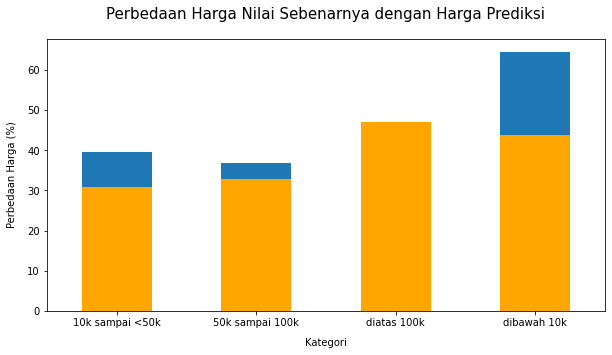

In [84]:
hasil.groupby('Category')['diff'].mean().plot(kind='bar', figsize=(10,5))
hasil2.groupby('Category')['diff'].mean().plot(kind='bar', figsize=(10,5), color='orange')
plt.title('Perbedaan Harga Nilai Sebenarnya dengan Harga Prediksi', fontsize=15, pad=20)
plt.ylabel('Perbedaan Harga (%)', labelpad=10)
plt.xlabel('Kategori', labelpad=10)
plt.xticks(rotation=0)
plt.show()

Setelah dilakukan *scaling* terlihat bahwa secara umum performa model mengalami perbaikan. Terlihat bahwa kini perbedaan harga prediksi tidak ada yang diatas 50%

In [50]:
import joblib

In [51]:
# save model
joblib.dump(best_grid_scaled, 'best_model_new.sav')

['best_model_new.sav']

## Kesimpulan dan Penutup

Beberapa kesimpulan yang dapat diperoleh yaitu:
1. Performa model yang dihasilkan tidak terlalu buruk dan dapat diterima
2. Hyperparameter tuning telah membantu meningkatkan performa dari model
3. Model dengan nilai label yang diskalakan secara umum memiliki performa yang lebih baik dari pada model dengan nilai label yang tidak diskalakan

Selain itu, menurut saya performa model akan lebih baik lagi apabila bagian area locality dipertimbangkan. Tampaknya dalam satu kota nilai sewa dapat bervariasi dengan variasi yang cukup besar. Variasi ini tentu akan mempengaruhi performa model. Namun, dikarenakan keterbatasan pengetahuan saya terkait area locality di India serta nilainya yang memiliki kardinalitas yang tinggi pada percobaan ini feature tersebut tidak saya gunakan.

Percobaan ini ditujukan sebagai latihan saya dalam menekuni dunia data science. Percobaan ini tidak dimaksudkan untuk tujuan komersial apapun.

Dibuat oleh Muhammad Rizaldi Yani\
rizaldiyani8@gmail.com